<a href="https://colab.research.google.com/github/juancarlosmontesdeoca/Proyecto-de-Regresion-Lineal/blob/main/Proyecto_Linear_Regression_jcmo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Proyecto Regresion Lineal**

In [29]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
!pip install tableone
from tableone import TableOne
import statsmodels.formula.api as smf




Paso 1: Cargar los datos

In [30]:
url = "https://breathecode.herokuapp.com/asset/internal-link?id=929&path=medical_insurance_cost.csv"

In [31]:
df = pd.read_csv(url)

**Planteamiento del Problema**

Se quiere conocer las variables que tienen incidencia en charges

**Paso 2: Realizacion de un EDA**

Exploracion de datos y limpieza

In [32]:
df.shape

(1338, 7)

1338 filas y 7 columnas

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Tipos de Variables:

Categoricas: sex, smoker, region

numericas: age, bmi, children, charges.



In [34]:
df.isnull().sum(); #corroborando valores faltantes que arriba vemos no hay

In [35]:
df.duplicated().sum() #revisando duplicados

np.int64(1)

In [36]:
df[df.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [37]:
df = df.drop_duplicates() #Eliminando duplicado

Revisando las categorias de las variables categorias y algunas numericas int

In [38]:
object_columnas = df.select_dtypes(include='object').columns
for col in object_columnas:
    print(f"Columna: {col}")
    print(df[col].value_counts())
    print()

Columna: sex
sex
male      675
female    662
Name: count, dtype: int64

Columna: smoker
smoker
no     1063
yes     274
Name: count, dtype: int64

Columna: region
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64



**Analisis de variables univariante**

In [39]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


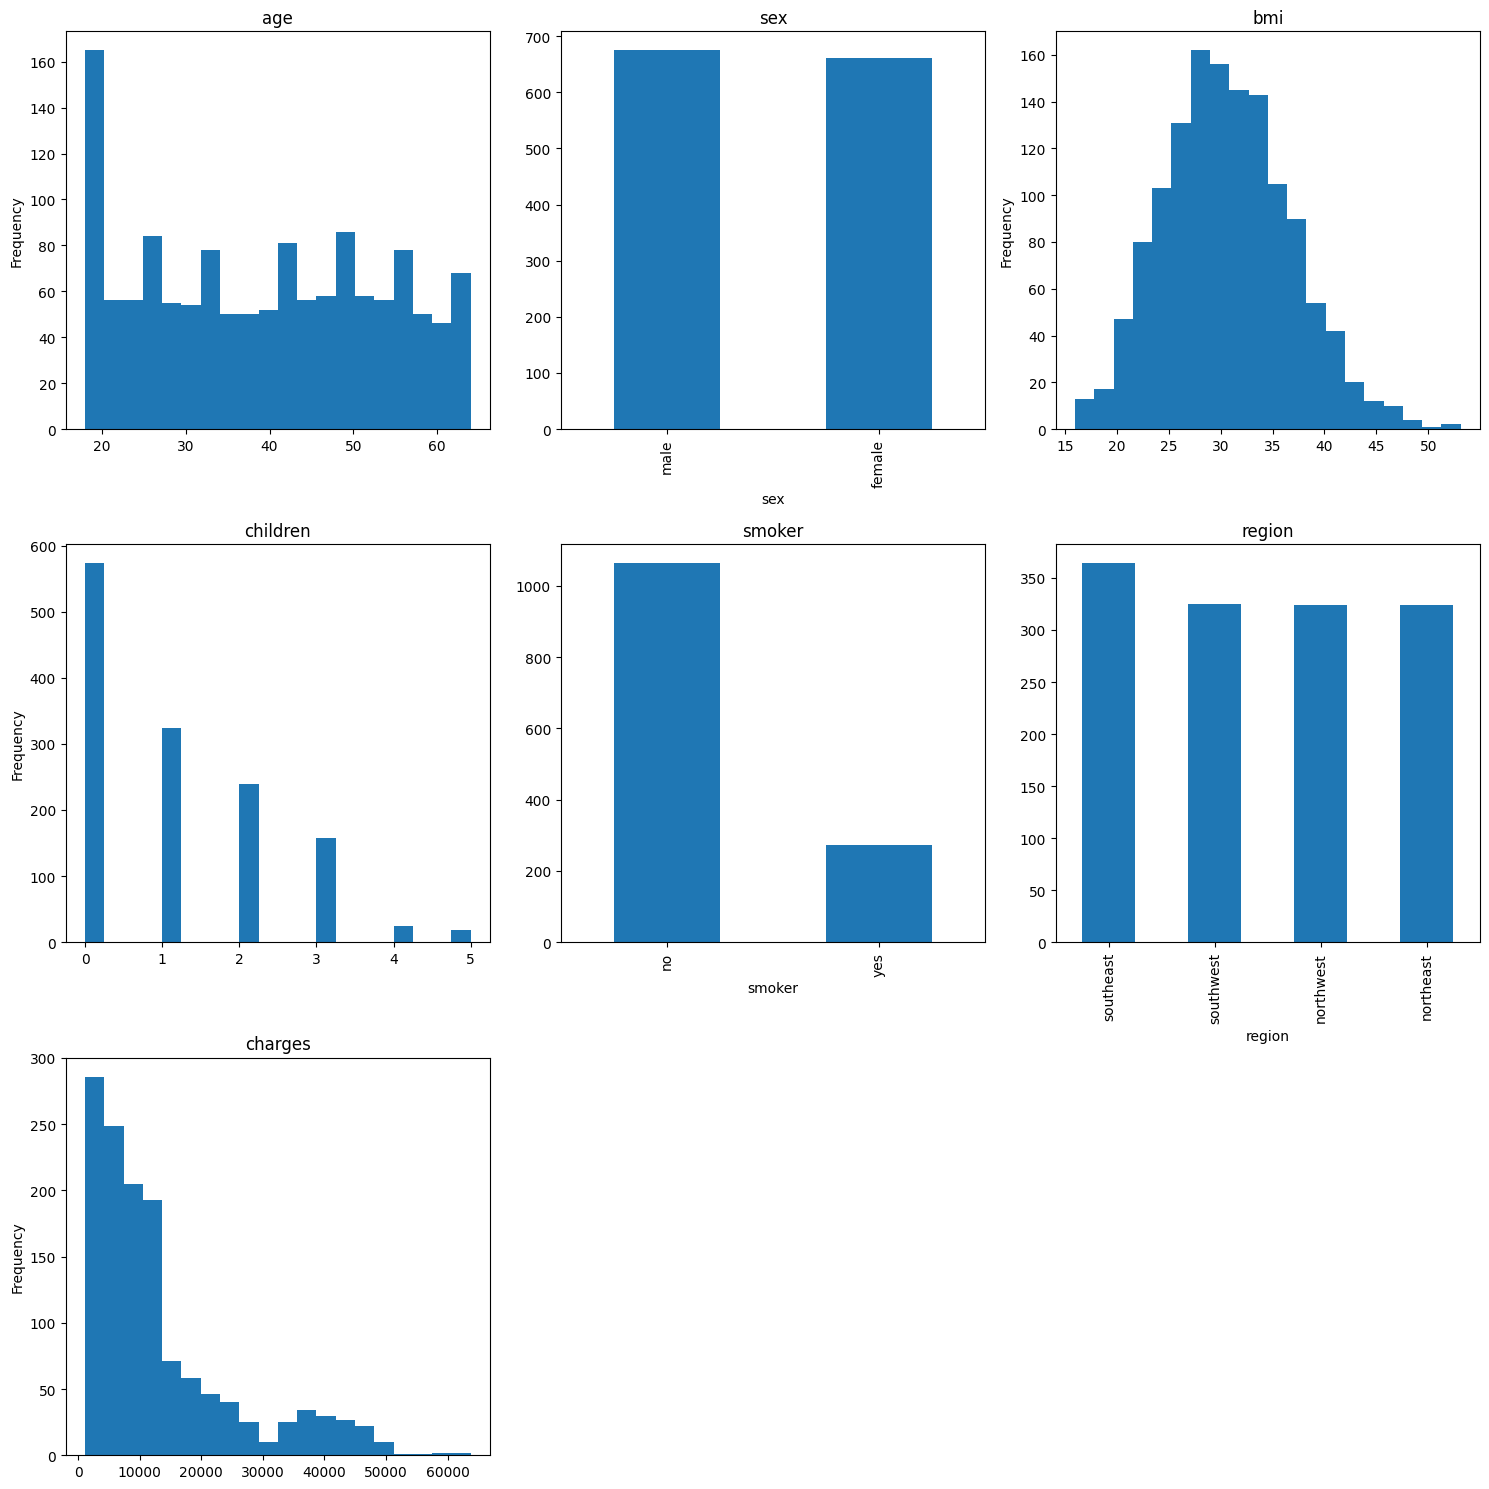

In [40]:
#Graficando como se comportan las variables antes de hacerle los test

import matplotlib.pyplot as plt

ncols = 3
cols = df.columns
nrows = (len(cols) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows))

i = 0
for row in range(nrows):
    for col_axis in range(ncols):
        if i >= len(cols):
            axes[row, col_axis].set_visible(False)  # oculta los sobrantes
        else:
            colname = cols[i]
            if df[colname].dtype == 'object':
                df[colname].value_counts().plot(kind='bar', ax=axes[row, col_axis])
            else:
                df[colname].plot(kind='hist', bins=20, ax=axes[row, col_axis])
            axes[row, col_axis].set_title(colname)
        i += 1

plt.tight_layout()
plt.show()



Observaciones:

Las variables 'age', 'bmi','charges', son variables no discretas, por lo tanto verificaremos su normalidad o no. Aunque por simple inspeccion visual, 'bmi' tiene mas comportamiento como una normal.

In [41]:
#verificando normalidad en las variables usando el test de Shapiro

columns = ['age', 'bmi', 'charges']
shapiro_results = {}

for column in columns:
    statistic, p_value = shapiro(df[column])
    shapiro_results[column] = {'statistic': statistic, 'p_value': p_value}
    print(f'{column},  p-value: {p_value}')

age,  p-value: 6.210452931581306e-22
bmi,  p-value: 2.575292856043621e-05
charges,  p-value: 1.1959741756687743e-36


En los 3 casos p-value < 0.05. Implica rechazar hipotesis nula y aceptar la alternativa, no existe evidencia en mis datos que las variables estudiadas tengan una distribucion normal

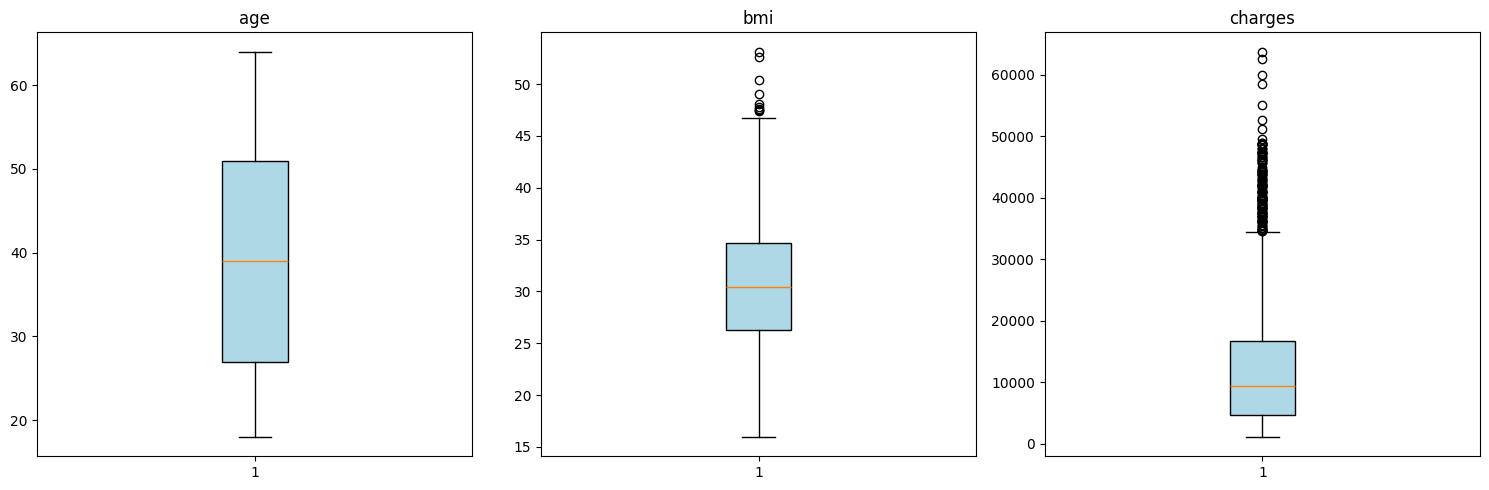

In [42]:
#graficando veficando como se comportan los datos en las variables nonnormales
columns = ['age', 'bmi', 'charges']

plt.figure(figsize=(15,5))
for i, col in enumerate(columns):
    plt.subplot(1,3,i+1)
    plt.boxplot(df[col],
                patch_artist=True,                    # permite colorear la caja
                boxprops=dict(facecolor='lightblue'))  # solo color en la caja
    plt.title(col)

plt.tight_layout()
plt.show()



Encontramos outliers en las variables bmi y charges, en especial en esta ultima.

Realizamos una preevaluacion mediante TableOne para ver cuales variables categoricas son candidatas a incidir en charge.

In [43]:
#Agrupando por region
categoricas = ['sex', 'smoker','children']
nonnormal = ['age', 'bmi', 'charges']
tabla =TableOne(df,
                nonnormal=nonnormal,
                categorical=categoricas,
                groupby='region',
                pval=True,
                htest_name=True)
display(tabla.tableone)

Grouped by region                           \
                                         Missing                  Overall   
n                                                                    1337   
age, median [Q1,Q3]                            0         39.0 [27.0,51.0]   
sex, n (%)              female                                 662 (49.5)   
                        male                                   675 (50.5)   
bmi, median [Q1,Q3]                            0         30.4 [26.3,34.7]   
children, n (%)         0                                      573 (42.9)   
                        1                                      324 (24.2)   
                        2                                      240 (18.0)   
                        3                                      157 (11.7)   
                        4                                        25 (1.9)   
                        5                                        18 (1.3)   
smoker, n (%)           no                                    1063 (79.5)   
                        yes                                    274 (20.5)   
charges, median [Q1,Q3]                        0  9386.2 [4746.3,16657.7]   

                                                          \
                                               northeast   
n                                                    324   
age, median [Q1,Q3]                     39.5 [27.0,51.0]   
sex, n (%)              female                161 (49.7)   
                        male                  163 (50.3)   
bmi, median [Q1,Q3]                     28.9 [24.9,32.9]   
children, n (%)         0                     147 (45.4)   
                        1                      77 (23.8)   
                        2                      51 (15.7)   
                        3                      39 (12.0)   
                        4                        7 (2.2)   
                        5                        3 (0.9)   
smoker, n (%)           no                    257 (79.3)   
                        yes                    67 (20.7)   
charges, median [Q1,Q3]         10057.7 [5194.3,16687.4]   

                                                         \
                                              northwest   
n                                                   324   
age, median [Q1,Q3]                    39.0 [26.0,51.2]   
sex, n (%)              female               164 (50.6)   
                        male                 160 (49.4)   
bmi, median [Q1,Q3]                    28.9 [25.7,32.8]   
children, n (%)         0                    131 (40.4)   
                        1                     74 (22.8)   
                        2                     66 (20.4)   
                        3                     46 (14.2)   
                        4                       6 (1.9)   
                        5                       1 (0.3)   
smoker, n (%)           no                   266 (82.1)   
                        yes                   58 (17.9)   
charges, median [Q1,Q3]         8977.0 [4733.6,14788.7]   

                                                         \
                                              southeast   
n                                                   364   
age, median [Q1,Q3]                    39.0 [26.8,51.0]   
sex, n (%)              female               175 (48.1)   
                        male                 189 (51.9)   
bmi, median [Q1,Q3]                    33.3 [28.6,37.8]   
children, n (%)         0                    157 (43.1)   
                        1                     95 (26.1)   
                        2                     66 (18.1)   
                        3                      35 (9.6)   
                        4                       5 (1.4)   
                        5                       6 (1.6)   
smoker, n (%)           no                   273 (75.0)   
                        yes                   91 (25.0)   
charges

La variable charges por region tiene un pvalue = 0.202 > 0.05 (nivel de significacion), lo que implica que no se encontraron evidencias significativas por region que incidan en esa variable

In [44]:
#agrupando por smoker
categoricas = ['sex','children','region']
nonnormal = ['age','bmi','charges']

# Construimos la tabla agrupando por 'smoker'
tabla_smoker = TableOne(df,
                        categorical=categoricas,
                        nonnormal=nonnormal,
                        groupby='smoker',
                        pval=True,
                        htest_name=True)

display(tabla_smoker.tableone)


Grouped by smoker                           \
                                            Missing                  Overall   
n                                                                       1337   
age, median [Q1,Q3]                               0         39.0 [27.0,51.0]   
sex, n (%)              female                                    662 (49.5)   
                        male                                      675 (50.5)   
bmi, median [Q1,Q3]                               0         30.4 [26.3,34.7]   
children, n (%)         0                                         573 (42.9)   
                        1                                         324 (24.2)   
                        2                                         240 (18.0)   
                        3                                         157 (11.7)   
                        4                                           25 (1.9)   
                        5                                           18 (1.3)   
region, n (%)           northeast                                 324 (24.2)   
                        northwest                                 324 (24.2)   
                        southeast                                 364 (27.2)   
                        southwest                                 325 (24.3)   
charges, median [Q1,Q3]                           0  9386.2 [4746.3,16657.7]   

                                                            \
                                                        no   
n                                                     1063   
age, median [Q1,Q3]                       40.0 [27.0,52.0]   
sex, n (%)              female                  547 (51.5)   
                        male                    516 (48.5)   
bmi, median [Q1,Q3]                       30.3 [26.3,34.4]   
children, n (%)         0                       458 (43.1)   
                        1                       263 (24.7)   
                        2                       185 (17.4)   
                        3                       118 (11.1)   
                        4                         22 (2.1)   
                        5                         17 (1.6)   
region, n (%)           northeast               257 (24.2)   
                        northwest               266 (25.0)   
                        southeast               273 (25.7)   
                        southwest               267 (25.1)   
charges, median [Q1,Q3]            7345.7 [3988.9,11363.0]   

                                                                      \
                                                         yes P-Value   
n                                                        274           
age, median [Q1,Q3]                         38.0 [27.0,49.0]   0.346   
sex, n (%)              female                    115 (42.0)   0.006   
                        male                      159 (58.0)           
bmi, median [Q1,Q3]                         30.4 [26.1,35.2]   0.935   
children, n (%)         0                         115 (42.0)   0.230   
                        1                          61 (22.3)           
                        2                          55 (20.1)           
                        3                          39 (14.2)           
                        4                            3 (1.1)           
                        5                            1 (0.4)           
region, n (%)           northeast                  67 (24.5)   0.064   
                        northwest                  58 (21.2)           
                        southeast                  91 (33.2)           
                        southwest                  58 (21.2)           
charges, median [Q1,Q3]            34456.3 [20826.2,41019.2]  <0.001   

                                                                              
                                                                        Test  
n                    

La variable charges por smoker tiene un pvalue = 0.001 < 0.05 (nivel de significacion), lo que implica que se encontraron evidencias significativas que smoker incide en la variable charges. Lo cual se corrobora con la diferencia de medianas por smoker

In [45]:
#agrupando por sexo
categoricas = ['children','region','smoker']
nonnormal = ['age','bmi','charges']

# Construimos la tabla agrupando por 'smoker'
tabla_smoker = TableOne(df,
                        categorical=categoricas,
                        nonnormal=nonnormal,
                        groupby='sex',
                        pval=True,
                        htest_name=True)

display(tabla_smoker.tableone)

Grouped by sex                           \
                                         Missing                  Overall   
n                                                                    1337   
age, median [Q1,Q3]                            0         39.0 [27.0,51.0]   
bmi, median [Q1,Q3]                            0         30.4 [26.3,34.7]   
children, n (%)         0                                      573 (42.9)   
                        1                                      324 (24.2)   
                        2                                      240 (18.0)   
                        3                                      157 (11.7)   
                        4                                        25 (1.9)   
                        5                                        18 (1.3)   
smoker, n (%)           no                                    1063 (79.5)   
                        yes                                    274 (20.5)   
region, n (%)           northeast                              324 (24.2)   
                        northwest                              324 (24.2)   
                        southeast                              364 (27.2)   
                        southwest                              325 (24.3)   
charges, median [Q1,Q3]                        0  9386.2 [4746.3,16657.7]   

                                                            \
                                                    female   
n                                                      662   
age, median [Q1,Q3]                       40.0 [27.0,51.8]   
bmi, median [Q1,Q3]                       30.1 [26.1,34.3]   
children, n (%)         0                       289 (43.7)   
                        1                       158 (23.9)   
                        2                       119 (18.0)   
                        3                        77 (11.6)   
                        4                         11 (1.7)   
                        5                          8 (1.2)   
smoker, n (%)           no                      547 (82.6)   
                        yes                     115 (17.4)   
region, n (%)           northeast               161 (24.3)   
                        northwest               164 (24.8)   
                        southeast               175 (26.4)   
                        southwest               162 (24.5)   
charges, median [Q1,Q3]            9413.0 [4885.2,14454.7]   

                                                                    \
                                                      male P-Value   
n                                                      675           
age, median [Q1,Q3]                       39.0 [26.0,51.0]   0.470   
bmi, median [Q1,Q3]                       30.7 [26.4,35.0]   0.102   
children, n (%)         0                       284 (42.1)   0.979   
                        1                       166 (24.6)           
                        2                       121 (17.9)           
                        3                        80 (11.9)           
                        4                         14 (2.1)           
                        5                         10 (1.5)           
smoker, n (%)           no                      516 (76.4)   0.006   
                        yes                     159 (23.6)           
region, n (%)           northeast               163 (24.1)   0.924   
                        northwest               160 (23.7)           
                        southeast               189 (28.0)           
                        southwest               163 (24.1)           
charges, median [Q1,Q3]            9377.9 [4654.0,19006.7]   0.694   

                                                   
                                             Test  
n                                                  
age, median [Q1,Q3]                Kruskal-Wallis  
bmi, median [Q1,Q3]                Kruskal-Wallis  
children,

La variable charges por sex tiene un pvalue = 0.694 > 0.05 (nivel de significacion), lo que implica que no se encontraron evidencias significativas por sex que inciden en la variable charges

In [46]:
#agrupando por children
categoricas = ['sex','region','smoker']
nonnormal = ['age','bmi','charges']

# Construimos la tabla agrupando por 'smoker'
tabla_smoker = TableOne(df,
                        categorical=categoricas,
                        nonnormal=nonnormal,
                        groupby='children',
                        pval=True,
                        htest_name=True)

display(tabla_smoker.tableone)

Grouped by children  \
                                              Missing   
n                                                       
age, median [Q1,Q3]                                 0   
sex, n (%)              female                          
                        male                            
bmi, median [Q1,Q3]                                 0   
smoker, n (%)           no                              
                        yes                             
region, n (%)           northeast                       
                        northwest                       
                        southeast                       
                        southwest                       
charges, median [Q1,Q3]                             0   

                                                            \
                                                   Overall   
n                                                     1337   
age, median [Q1,Q3]                       39.0 [27.0,51.0]   
sex, n (%)              female                  662 (49.5)   
                        male                    675 (50.5)   
bmi, median [Q1,Q3]                       30.4 [26.3,34.7]   
smoker, n (%)           no                     1063 (79.5)   
                        yes                     274 (20.5)   
region, n (%)           northeast               324 (24.2)   
                        northwest               324 (24.2)   
                        southeast               364 (27.2)   
                        southwest               325 (24.3)   
charges, median [Q1,Q3]            9386.2 [4746.3,16657.7]   

                                                            \
                                                         0   
n                                                      573   
age, median [Q1,Q3]                       36.0 [22.0,55.0]   
sex, n (%)              female                  289 (50.4)   
                        male                    284 (49.6)   
bmi, median [Q1,Q3]                       30.3 [26.1,34.8]   
smoker, n (%)           no                      458 (79.9)   
                        yes                     115 (20.1)   
region, n (%)           northeast               147 (25.7)   
                        northwest               131 (22.9)   
                        southeast               157 (27.4)   
                        southwest               138 (24.1)   
charges, median [Q1,Q3]            9863.5 [2741.9,14449.9]   

                                                            \
                                                         1   
n                                                      324   
age, median [Q1,Q3]                       40.0 [30.0,49.0]   
sex, n (%)              female                  158 (48.8)   
                        male                    166 (51.2)   
bmi, median [Q1,Q3]                       30.0 [26.6,34.2]   
smoker, n (%)           no                      263 (81.2)   
                        yes                      61 (18.8)   
region, n (%)           northeast                77 (23.8)   
                        northwest                74 (22.8)   
                        southeast                95 (29.3)   
                        southwest                78 (24.1)   
charges, median [Q1,Q3]            8483.9 [4791.6,15632.1]   

                                                            \
                                                         2   
n                                                      240   
age, median [Q1,Q3]                       40.0 [30.0,48.0]   
sex, n (%)              female                  119 (49.6)   
                        male                    121 (50.4)   
bmi, median [Q1,Q3]                       31.6 [25.8,35.4]   
smoker, n (%)           no                      185 (77.1)   
                        yes                      55 (22.9)   
region, n (%)           northeast                51 (21.2)   
        

La variable charges por children tiene un pvalue = 0.001 < 0.05 (nivel de significacion), lo que implica que se encontraron evidencias significativas por children que inciden en la variable charges. Las medianas no siguen un crecimiento lineal, porque con 2 hijos y 5 tienden a bajar con respecto al grupo anterior. En cambio, esa variable children no tiene incidencia significativa en las variables age, sex, bmi, smoker y region dado que en todas ellas tiene un pvalue > 0.05.

Observaciones del Analisis de variables univariante:

1.Las variables age, bmi, y charges, despues de realizar el test de Shapiro se pudo determinar que no existe evidencia en los datos que indiquen que siguen una distribucion normal, por lo tanto son variables no normales.

2. Las variables smoker y children, luego de aplicarles el test de Kruskall-Wallis se pudo determinar que se encontraron evidencias significativas que dichas variables inciden en charges.

3. Las variables sex y region, no incidirian en la variable charges.

4. Las variables bmi y charges tienen valores outliers.

5. La variable children no tiene incidencia significativa en las variables age, sex, bmi, smoker y region

**Analisis de variable bivariante**

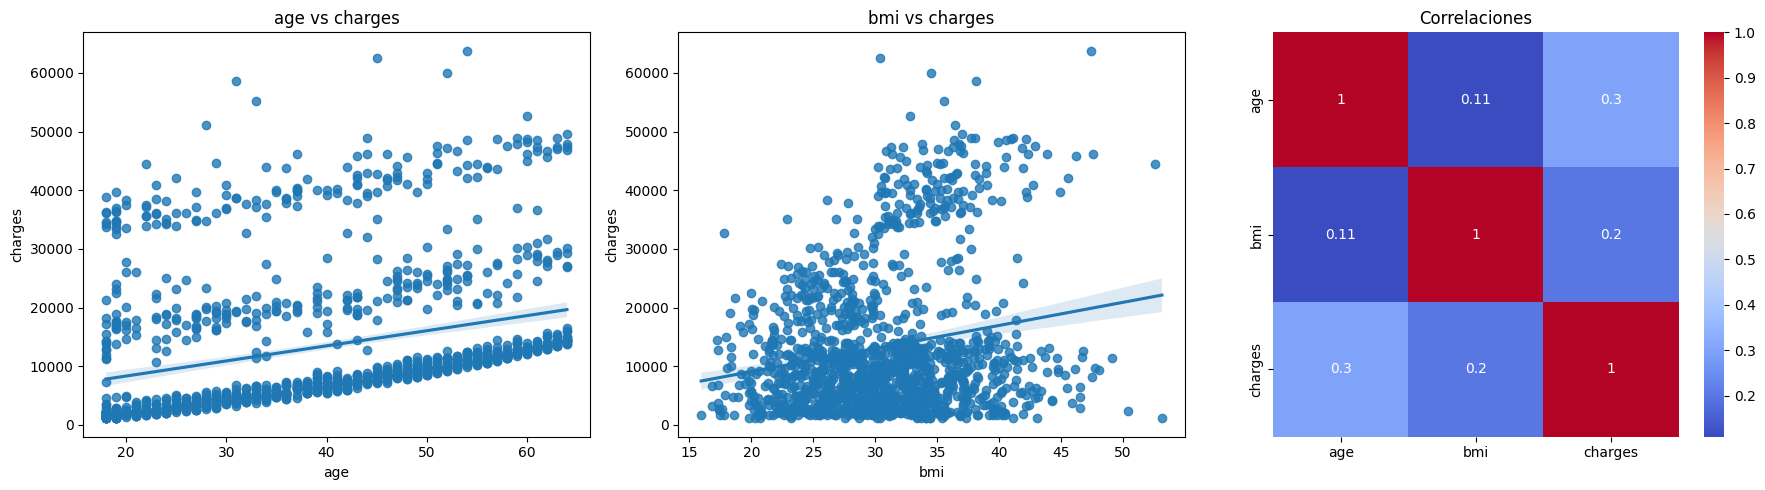

In [47]:
#analisis numerico - numerico
#regplots en líneas

fig, axes = plt.subplots(1,3, figsize=(18,5))

sns.regplot(x='age', y='charges', data=df, ax=axes[0])
axes[0].set_title("age vs charges")

sns.regplot(x='bmi', y='charges', data=df, ax=axes[1])
axes[1].set_title("bmi vs charges")

sns.heatmap(df[['age','bmi','charges']].corr(), annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title("Correlaciones")

plt.tight_layout()
plt.show()



La variable age presenta un coeficiente de correlación de 0.3 con charges, lo que refleja una relación positiva de magnitud moderada. Esto sugiere que, en general, a medida que aumenta la edad, los costos médicos (charges) tienden también a incrementarse.

La variable bmi presenta un coeficiente de correlación de 0.2 con charges, lo que indica una relación positiva débil. Esto sugiere que, en general, a medida que aumenta el índice de masa corporal, los costos médicos (charges) tienden a incrementarse ligeramente, aunque la asociación es baja.

La correlación de 0.11 entre age y bmi indica una relación positiva muy débil. A medida que aumenta la edad, el BMI tiende a aumentar ligeramente, pero la asociación es muy baja y no implica un incremento del 11% por año.

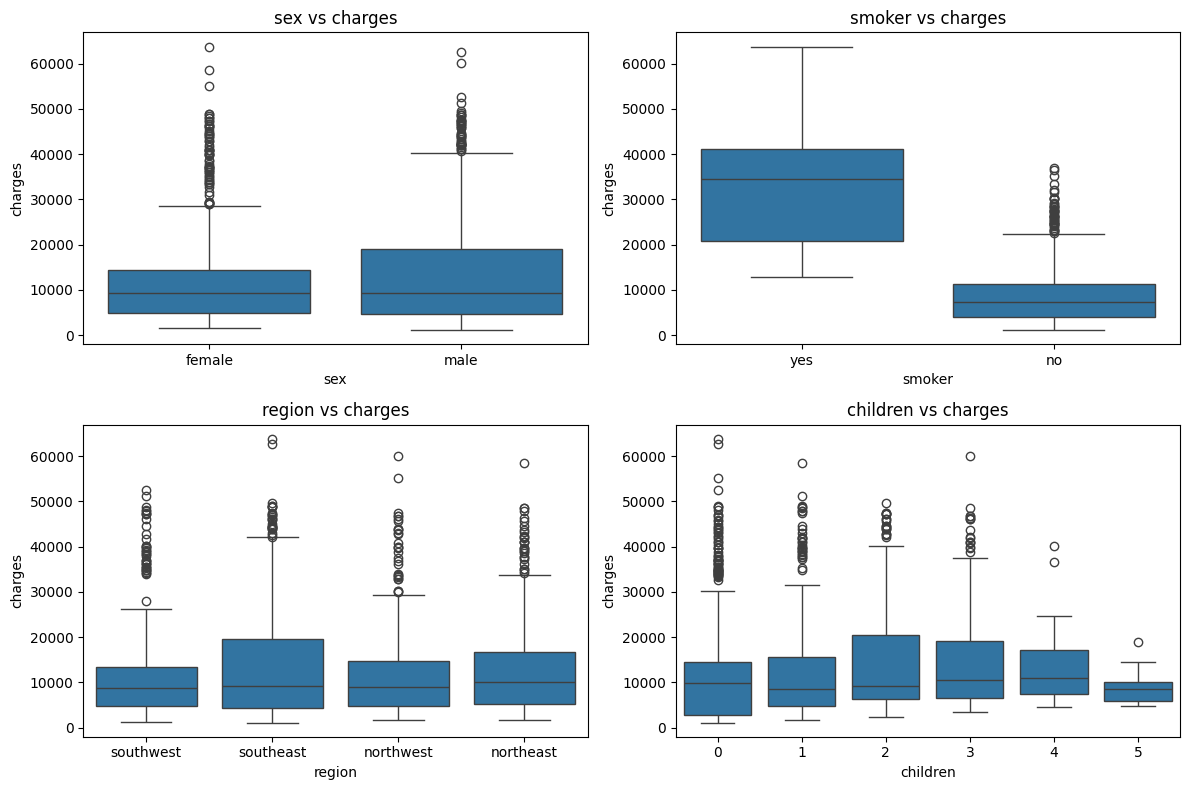

In [48]:
#Analisis categorico-numerico

categoricas = ['sex','smoker','region','children']

plt.figure(figsize=(12,8))
for i, col in enumerate(categoricas):
    plt.subplot(2,2,i+1)   # 2 filas, 2 columnas
    sns.boxplot(x=col, y='charges', data=df)
    plt.title(f"{col} vs charges")

plt.tight_layout()
plt.show()

Las variables smoker y children son las que tienen diferencias mas marcadas entre la mediana y el rango intercuartil entres sus grupos, por lo que son variables que incidirian en charges. Mientras que las variables sex y region tienen diferencias menos marcadas en las medianas de cada grupo. Todo lo anterior, constraste con lo obtenido a traves del test de Kruskall Wallis aplicado a dichas variables.


**Ingenieria de Caracteristicas**

De acuerdo con los analisis realizado en el analisis univariante y multivariante, podemos reducir nuestra DataFrame a las variables que inciden en charges, las cuales son:

Categoricas: smoker, children

numericas: age, bmi (nonnormales)

variable objetivo: charges (nonnormales)

In [49]:
df_nuevo = df.drop(columns=['region','sex'])


Tratamiento de los outliers

In [50]:
df.shape

(1337, 7)

In [51]:
#Las variables age, bmi y charges al ser nonnormales se usara el rango intercuartil
#para tratar el tema de los outliers

def eliminar_outliers_iqr(df, col):
    q1, q3 = df_nuevo[col].quantile([0.25,0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    antes = len(df_nuevo)
    df_filtrado = df_nuevo[(df_nuevo[col] >= low) & (df_nuevo[col] <= high)]
    despues = len(df_filtrado)
    print(f"{col}: IQR={iqr:.2f}, límites={low:.2f}-{high:.2f}, antes={antes}, después={despues}, eliminados={antes-despues}")
    print()
    return df_filtrado

# Aplicar a las columnas deseadas
df_filtrado = df_nuevo.copy()
for c in ['age','bmi','charges']:
    df_filtrado = eliminar_outliers_iqr(df_filtrado, c)



age: IQR=24.00, límites=-9.00-87.00, antes=1337, después=1337, eliminados=0

bmi: IQR=8.41, límites=13.67-47.32, antes=1337, después=1328, eliminados=9

charges: IQR=11911.37, límites=-13120.72-34524.78, antes=1337, después=1198, eliminados=139



In [52]:
df_filtrado.shape

(1198, 5)

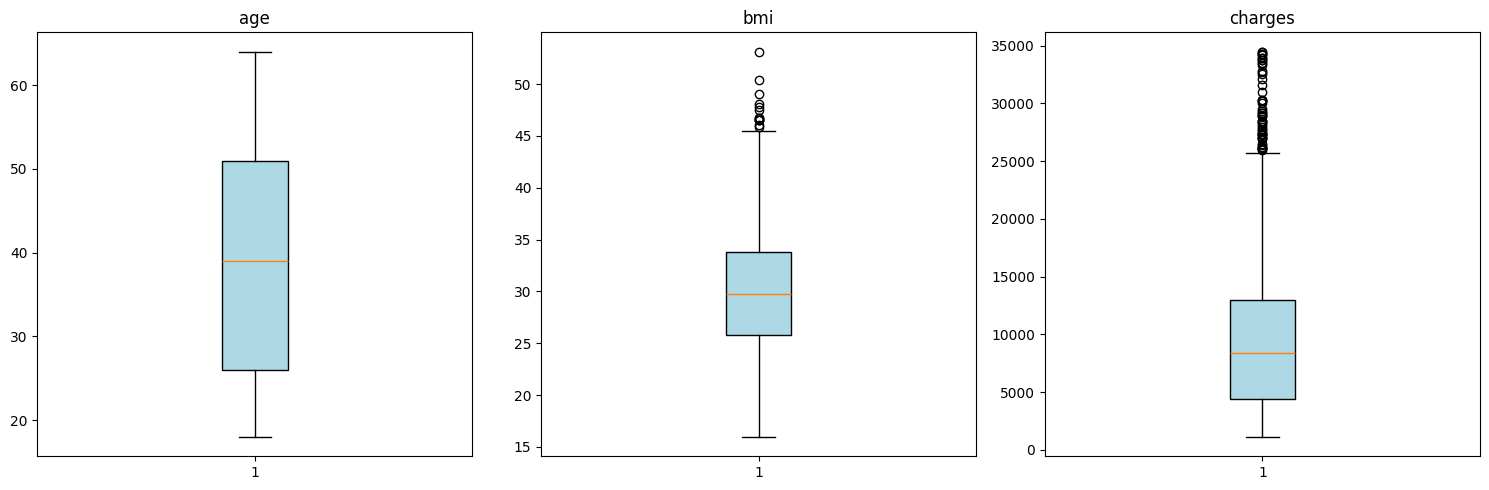

In [53]:
columns = ['age', 'bmi', 'charges']

plt.figure(figsize=(15,5))
for i, col in enumerate(columns):
    plt.subplot(1,3,i+1)
    plt.boxplot(df_filtrado[col],
                patch_artist=True,                # permite colorear la caja
                boxprops=dict(facecolor='lightblue'))  # solo color en la caja
    plt.title(col)

plt.tight_layout()
plt.show()

En bmi se redujeron bastante los valores atipicos, mientras que en charges aun prevalecen algunos pero estan dentro de la cota q3 + 1.5*iqr, donde q3 (percentil 75) y iqr (rango intercuartil), por lo tanto se dejaran esos valores.

Analisis de valores faltantes

Ya se habia revisado, igual se verificara para seguir los pasos del EDA

In [54]:
df_filtrado.isnull().sum().sort_values(ascending=False)

,0
age,0
bmi,0
children,0
smoker,0
charges,0


Analisis de Regresion Lineal

In [55]:
#Usando el DataFrame original para contrastar con los resultados obtenidos
#en los apartados anteriores

print(smf.ols("charges ~ age +C(sex)+ bmi+children+C(smoker)+C(region)", data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.0
Date:                Wed, 17 Dec 2025   Prob (F-statistic):               0.00
Time:                        00:29:49   Log-Likelihood:                -13538.
No. Observations:                1337   AIC:                         2.709e+04
Df Residuals:                    1328   BIC:                         2.714e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.19

Interpretacion:

*smoker tiene un coeficiente aproximado de 23850 por lo que ser fumador aumenta los charges en promedio en esa cantidad. Cuenta con un t=57.7 y pvalue = 0.000 < 0.001, lo que indica que la variable tiene un efecto muy significativo para explicar gran parte de la variacion en el modelo.

*age tiene un coeficiente aproximado de 257, lo que se traduce que cada año adicional de edad aumenta los charges en promedio 257. Igualmente, cuenta con un t=21.6 y pvalue = 0.000 < 0.001, por lo que es signifitcativo, aunque con menor impacto que smoker.

*bmi presenta un coeficiente de 339, lo que se traduce que cada punto de indice de masa corporal aumenta los charges en promedio en 339. Tiene un t=11.9 y pvalue = 0.000 < 0.001, lo que indica que es muy significaticativo, menos relevante que age y smoker.

*children con un coeficiente de 475, que se interpreta que cada hijo aumenta los charges en promedio en 475. Cuenta con un t=3.45 y pvalue = 0.000 < 0.001 es significativo pero menos que los anteriores.
*region coeficienes negativos southeast (-1035) y southwest (-960) pero con pvalue entre 0.03 y 0.045, respectivamente, lo que indica que hay cierta diferencia de costos en esas regiones pero su efecto es pequeño. En el caso de northwest, cuenta con pvalue = 0.464 > 0.05, por lo que no aporta al modelo.

*sex con un pvalue = 0.698 > 0.05, lo que se traduce que no tiene incidencia en los charges.



**Conclusion**:

# De acuerdo con los resultados anteriores, en contraste con el EDA, se corrobora efectivamente las variables categoricas smoker y children, asi como las variables numericas age y bmi, pueden ser buenas predictoras de charges.